# 1. Setup and get Data

In [ ]:
!pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
# Import libraries
import os
import time
import uuid # Help create unique file names identifier
import cv2

In [ ]:
# Define the directory structure
base_dir = 'data'
sub_dirs = ['images', 'labels']

# Create the base directory
os.makedirs(base_dir, exist_ok=True)

# Create subdirectories inside the base directory
for sub_dir in sub_dirs:
    os.makedirs(os.path.join(base_dir, sub_dir), exist_ok=True)

In [ ]:
# The data path
IMAGES_PATH = os.path.join('data','images') # Requires to create dir data. Inside data create dir images and dir labels
# Number of images
number_images = 30

In [ ]:
# Capture images of face using machine's camera
cap = cv2.VideoCapture(0) # Establish connection with computer's camera, pass through camera number
# Looping over range of images
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read() #Image size is 480x640 is RGB

    # Write down the image combine with a specific UUID path
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame) # Show again on the screen
    # 0.5 seconds to change position
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [ ]:
# Label the images
!labelme

/bin/bash: line 1: labelme: command not found


In [ ]:
# Unzip the data file with path /content/data.zip (Colab only)
!unzip /content/data.zip

Archive:  /content/data.zip
   creating: data/
   creating: data/images/
  inflating: data/images/0606af19-d6e3-11ef-8d52-646c8072e71e.jpg  
  inflating: data/images/06641ca5-d6e3-11ef-9e4e-646c8072e71e.jpg  
  inflating: data/images/06b7a07a-d6e3-11ef-8343-646c8072e71e.jpg  
  inflating: data/images/0707b620-d6e3-11ef-9bfa-646c8072e71e.jpg  
  inflating: data/images/0756f331-d6e3-11ef-9682-646c8072e71e.jpg  
  inflating: data/images/07a7c9a9-d6e3-11ef-8240-646c8072e71e.jpg  
  inflating: data/images/07f6c12a-d6e3-11ef-8175-646c8072e71e.jpg  
  inflating: data/images/0847228e-d6e3-11ef-9f37-646c8072e71e.jpg  
  inflating: data/images/0897d242-d6e3-11ef-9ea9-646c8072e71e.jpg  
  inflating: data/images/08e80e12-d6e3-11ef-aa51-646c8072e71e.jpg  
  inflating: data/images/093807f4-d6e3-11ef-85d0-646c8072e71e.jpg  
  inflating: data/images/09894818-d6e3-11ef-9824-646c8072e71e.jpg  
  inflating: data/images/09d9a4db-d6e3-11ef-928f-646c8072e71e.jpg  
  inflating: data/images/0a2af785-d6e3-11ef

# 2. Review Dataset and Build Image Loading Function

In [ ]:
# Import the libraries
import tensorflow as tf
import json # For labels
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
# Limit GPU memory Growth
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# Load Image into TF DataPipeline
images = tf.data.Dataset.list_files('data/images/*.jpg', shuffle=False)

In [ ]:
# Check if the full path of images have been pickup
images.as_numpy_iterator().next()

b'data/images/0606af19-d6e3-11ef-8d52-646c8072e71e.jpg'

In [ ]:
# Create a function that load an image
def load_image(x):
  byte_img = tf.io.read_file(x)
  img = tf.io.decode_jpeg(byte_img)
  return img

In [ ]:
# Map each elements in the file path with the load_image function
images = images.map(load_image)

In [ ]:
# Check again to make sure the mapping is correct
images.as_numpy_iterator().next()

In [ ]:
# Check the datatype
type(images)

tensorflow.python.data.ops.map_op._MapDataset

In [ ]:
# Visualize the images of in many batches
image_generator = images.batch(4).as_numpy_iterator()

In [ ]:
plot_images = image_generator.next() # Run multiple times to get different images

In [ ]:
# Loop through to visualize the images
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

# 3. Partition Unaugmented Data

In [ ]:
# Create Train dir, Val dir, Test dir with each have images and labels dirs
for folder in ['train','test','val']:
    for file in ['images','labels']:
        os.makedirs(os.path.join('data', folder, file))

In [ ]:
from sklearn.model_selection import train_test_split
# Paths to the data folders
data_dir = 'data' # The path of the root data folder
images_dir = os.path.join(data_dir, 'images') # The path of the images folder in data
# List all image files
image_files = sorted([f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])
# Train-test-validation split (70%-20%-10%)
train_files, temp_files = train_test_split(image_files, test_size=0.3, random_state=42)
val_files, test_files = train_test_split(temp_files, test_size=0.33, random_state=42)  # 0.33 * 0.3 = ~10%


In [ ]:
import shutil
# Helper function to copy files from images_files to the directories
def copy_files(file_list,images_dir, data_dir,dest_folder):
    for file_name in file_list:
        src_path = os.path.join(images_dir, file_name)
        dest_path = os.path.join(data_dir, dest_folder, 'images', file_name)
        shutil.copy(src_path, dest_path)

# Copy files to the respective directories
copy_files(train_files,images_dir,data_dir, 'train')
copy_files(val_files,images_dir, data_dir ,'val')
copy_files(test_files,images_dir, data_dir,'test')

In [ ]:
# Mapping what in images folder to the labels folder
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):

        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)

# 4. Apply AlbumAugmentation for Transformation of Images and Labels

In [ ]:
import albumentations as alb

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
# Define an augmentation pipeline
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), # Crop pictures to 450x450 pixels
                         alb.HorizontalFlip(p=0.5),  # Flip horizontal
                         alb.RandomBrightnessContrast(p=0.2), # Change the Brightness
                         alb.RandomGamma(p=0.2),  # Change the Gamma Filter
                         alb.RGBShift(p=0.2),  # Change the intensity of the color
                         alb.VerticalFlip(p=0.5)],  # Flip Vertical
                       bbox_params=alb.BboxParams(format='albumentations',
                                                  label_fields=['class_labels']))

## 4.1 Testing the Augmentor

In [ ]:
# Load an Example image and label
example_file = "06641ca5-d6e3-11ef-9e4e-646c8072e71e"

# Loading the image
img = cv2.imread(os.path.join('data','train','images',example_file + ".jpg"))
# Loading the json label
with open(os.path.join('data','train','labels',example_file + '.json'), 'r') as f:
    label = json.load(f)

In [ ]:
# Extract Coordinates and Rescale to Match Image Resolution
coords = [0,0,0,0] #x1.y1,x2,y2
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]
# Normalization
coords = list(np.divide(coords, [640,480,640,480]))
coords

[0.5425091911764707,
 0.004442401960784366,
 0.8504136029411764,
 0.44638480392156865]

In [ ]:
# Now run through the image through augmentor
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

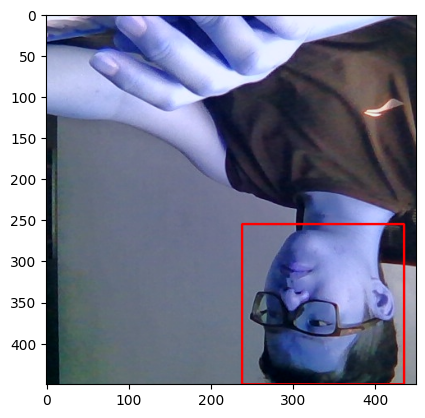

In [ ]:
# Show the image as well as the rectangle box
cv2.rectangle(augmented['image'], # The rectangle background
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)), # Rectangle first point
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), # Rectangle second point
                    (255,0,0), 2) # The rectangle color

plt.imshow(augmented['image'])

## 4.2 Implement the Augmentation pipeline for the whole data

In [ ]:
# Create aug_data folder, the structure is similar to the data folder
# Create Train dir, Val dir, Test dir with each have images and labels dirs
for folder in ['train','test','val']:
    for file in ['images','labels']:
        os.makedirs(os.path.join('aug_data', folder, file))

In [ ]:
# This loop do the augementation of the whole data
for partition in ['train','test','val']: # Run through all the dir
    for image in os.listdir(os.path.join('data', partition, 'images')): # Takes all the image
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001] # Default label, when image don't have face
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path): # Check if that image have a label path, if yes run the normalization, else skip this part
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try:
            for x in range(60): # When creating 60 images base on 1 image
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image']) # Saving those augmented images in dir aug_data

                annotation = {}
                annotation['image'] = image # save the image name

                if os.path.exists(label_path): # Other modification in labels
                    if len(augmented['bboxes']) == 0:  # Modification of the bbox
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 # not face
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1 # face
                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0  # not face


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

/usr/local/lib/python3.11/dist-packages/albumentations/core/bbox_utils.py:478: RuntimeWarning: invalid value encountered in divide
  & (clipped_box_areas / denormalized_box_areas >= min_visibility - epsilon)


In [ ]:
# Load Augmented Images to Tensorflow Dataset - Training set
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120))) # Compress down even more to save resources
train_images = train_images.map(lambda x: x/255)

In [ ]:
# Load Augmented Images to Tensorflow Dataset - Testing set
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120))) # Compress down even more to save resources
test_images = test_images.map(lambda x: x/255)

In [ ]:
# Load Augmented Images to Tensorflow Dataset - Validation set
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120))) # Compress down even more to save resources
val_images = val_images.map(lambda x: x/255)

# 5. Prepare Labels

In [ ]:
# A load Labels function to get the class 0 - none , 1 - face
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)

    return [label['class']], label['bbox']

In [ ]:
# Training set labels
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
# Testing set labels
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
# Validation set labels
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

# 6. Combine Label and Image samples

In [ ]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels) # Getting the length

(3780, 3780, 540, 540, 1080, 1080)

In [ ]:
# Joining Train dataset
train = tf.data.Dataset.zip((train_images, train_labels)) # Combine with zip
train = train.shuffle(5000) # Shuffle the sets
train = train.batch(8) # Batching to 8 label-image each
train = train.prefetch(4) # Eliminate bottle neck

In [ ]:
# Joining Test Dataset
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [ ]:
# Joining Validation dataset
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [ ]:
train.as_numpy_iterator().next()[0].shape # 8 images

(8, 120, 120, 3)

In [ ]:
train.as_numpy_iterator().next()[1] # 8 labels and 8 bboxes

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.5615 , 0.     , 0.9766 , 0.429  ],
        [0.7275 , 0.     , 1.     , 0.0996 ],
        [0.586  , 0.     , 1.     , 0.4443 ],
        [0.2446 , 0.61   , 0.608  , 1.     ],
        [0.1809 , 0.     , 0.531  , 0.3467 ],
        [0.3394 , 0.     , 0.6987 , 0.4219 ],
        [0.3035 , 0.6475 , 0.657  , 1.     ],
        [0.3088 , 0.00415, 0.6787 , 0.4624 ]], dtype=float16))

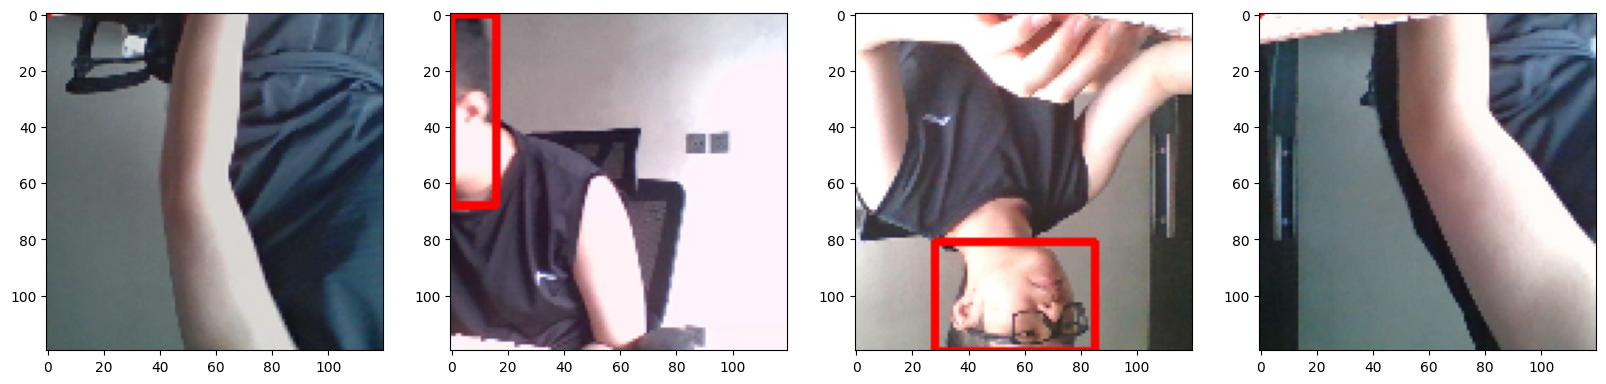

In [ ]:
# Load a sample
data_samples = train.as_numpy_iterator()
res = data_samples.next()

# Plot the sample
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    # Create a copy of the image, since we cannot read the file in read-only mode
    sample_image_copy = sample_image.copy()

    # Draw the rectangle on the copy
    cv2.rectangle(sample_image_copy,  # Pass the copy to cv2.rectangle
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                        (255,0,0), 2)

    ax[idx].imshow(sample_image_copy) # Display the modified copy

# 7. Build our deep learning model

## 7.1 Build model

In [ ]:
# Import Layers and Base Networks
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [ ]:
# Dosnload VGG16
vgg = VGG16(include_top=False) # We don't need the final layers of VGG

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Looking at the vgg model
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Defining our neural network
def build_model():
  input_layer = Input(shape=(120,120,3))
  vgg = VGG16(include_top=False)(input_layer)

  # Classification Model - Determine weather there is a face or not
  f1 = GlobalMaxPooling2D()(vgg) # Pool the result of VGG
  class1 = Dense(2048, activation='relu')(f1)
  class2 = Dense(1, activation='sigmoid')(class1) # 1 output since it is binary classification

  # Bounding box model - Determine the box locations
  f2 = GlobalMaxPooling2D()(vgg) # Pool the result of VGG
  regress1 = Dense(2048, activation='relu')(f2)
  regress2 = Dense(4, activation='sigmoid')(regress1) # 4 output represent 4 points like our bbox, sigmoid since our bbox is normalize when training

  facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
  return facetracker

## 7.2 Builded and define losses



In [ ]:
# Building the model
facetracker = build_model()
facetracker.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 120, 120, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 3, 3, 512)      │     14,714,688 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling2d_4    │ (None, 512)            │              0 │ vgg16[0][0]            │
│ (GlobalMaxPooling2D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling2d_5    │ (None, 512)            │              0 │ vgg16[0][0]            │
│ (GlobalMaxPooling2D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 2048)           │      1,050,624 │ global_max_pooling2d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 2048)           │      1,050,624 │ global_max_pooling2d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 1)              │          2,049 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 4)              │          8,196 │ dense_10[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define Optimizer and Learning Rate
import tensorflow as tf

# Example: Define the number of batches per epoch
batches_per_epoch = len(train)

# Calculate the decay rate based on your formula
lr_decay = (1. / 0.75 - 1) / batches_per_epoch

# Define a custom learning rate schedule
class CustomLRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, decay_rate):
        self.initial_learning_rate = initial_learning_rate
        self.decay_rate = decay_rate

    def __call__(self, step):
        # Formula to calculate the learning rate at a given step
        return self.initial_learning_rate / (1 + self.decay_rate * step)

# Initialize the custom learning rate schedule
initial_learning_rate = 0.0001
lr_schedule = CustomLRSchedule(
    initial_learning_rate=initial_learning_rate,
    decay_rate=lr_decay,
)

# Set the optimizer using the custom learning rate schedule
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Print the learning rate at different steps for testing
for step in range(0, 10 * batches_per_epoch, batches_per_epoch):
    print(f"Step {step}: Learning Rate = {lr_schedule(step)}")


Step 0: Learning Rate = 0.0001
Step 473: Learning Rate = 7.500000000000001e-05
Step 946: Learning Rate = 6.000000000000001e-05
Step 1419: Learning Rate = 5.000000000000001e-05
Step 1892: Learning Rate = 4.285714285714286e-05
Step 2365: Learning Rate = 3.750000000000001e-05
Step 2838: Learning Rate = 3.333333333333334e-05
Step 3311: Learning Rate = 3.0000000000000008e-05
Step 3784: Learning Rate = 2.727272727272728e-05
Step 4257: Learning Rate = 2.5000000000000008e-05


In [ ]:
# Define Localization loss - Mean Squared Error
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))

    return delta_coord + delta_size

In [ ]:
# Fitted our loss function
classloss = tf.keras.losses.BinaryCrossentropy() # Works just fine
regressloss = localization_loss

## 7.3 Create a Custom Model pipeline

In [ ]:
# FaceTracker customer model
class FaceTracker(Model):
    def __init__(self, facetracker,  **kwargs):  # Init the FaceTracker model from 7.1
        super().__init__(**kwargs)
        self.model = facetracker

    def compile(self, opt, classloss, localizationloss, **kwargs): # Added our loss function and optimizer
        super().compile(**kwargs)
        self.closs = classloss # Classification loss
        self.lloss = localizationloss # Reg Loss
        self.opt = opt # Optimizer Adam

    def train_step(self, batch, **kwargs):

        X, y = batch # Unpact the batch of data

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True) # Fitting the training data

            # Ensure classes and y[0] have the correct shape
            classes = tf.reshape(classes, [-1])  # Reshape to a 1D tensor
            y_true = tf.reshape(y[0], [-1]) # Reshape to a 1D tensor

            # Calculate the losses
            batch_classloss = self.closs(y_true, classes) # Pass y_true instead of y[0]
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords) #Passes the Reg Loss
            total_loss = batch_localizationloss+0.5*batch_classloss # The Total loss
            # Calulate the gradient
            grad = tape.gradient(total_loss, self.model.trainable_variables) # Calculate the Gradient

        opt.apply_gradients(zip(grad, self.model.trainable_variables)) # Gradient descent to minimize the loss

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}


    def test_step(self, batch, **kwargs): # Apply for test set, different is there is no back-probagation
        X, y = batch # # Unpact the batch of data

        classes, coords = self.model(X, training=False) # Fitting the data to the model, but not as training
        classes = tf.reshape(classes, [-1])  # Reshape to a 1D tensor
        y_true = tf.reshape(y[0], [-1]) # Reshape to a 1D tensor
        # Calculate losses
        batch_classloss = self.closs(y_true, classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [ ]:
# Set up the model
model = FaceTracker(facetracker)
# Complie the model
model.compile(opt, classloss, regressloss)

## 7.4 Train and Test the model

In [ ]:
logdir = 'logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 55s 91ms/step - class_loss: 0.0071 - regress_loss: 0.0362 - total_loss: 0.0398 - val_class_loss: 0.0036 - val_regress_loss: 0.0353 - val_total_loss: 0.0371
Epoch 2/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 41s 73ms/step - class_loss: 0.0013 - regress_loss: 0.0155 - total_loss: 0.0162 - val_class_loss: 1.3188e-04 - val_regress_loss: 0.0188 - val_total_loss: 0.0189
Epoch 3/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 40s 71ms/step - class_loss: 0.0058 - regress_loss: 0.0261 - total_loss: 0.0290 - val_class_loss: 1.0730e-04 - val_regress_loss: 0.0217 - val_total_loss: 0.0217
Epoch 4/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 39s 71ms/step - class_loss: 2.7818e-04 - regress_loss: 0.0074 - total_loss: 0.0075 - val_class_loss: 2.9728e-06 - val_regress_loss: 0.0061 - val_total_loss: 0.0061
Epoch 5/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 40s 70ms/step - class_loss: 5.6168e-05 - regress_loss: 0.0043 - total_loss: 0.0043 - val_class_loss: 1.5960e-05 - val_regress_loss: 0.0031 - val_total_loss: 0.0

# 8. Plot Performance

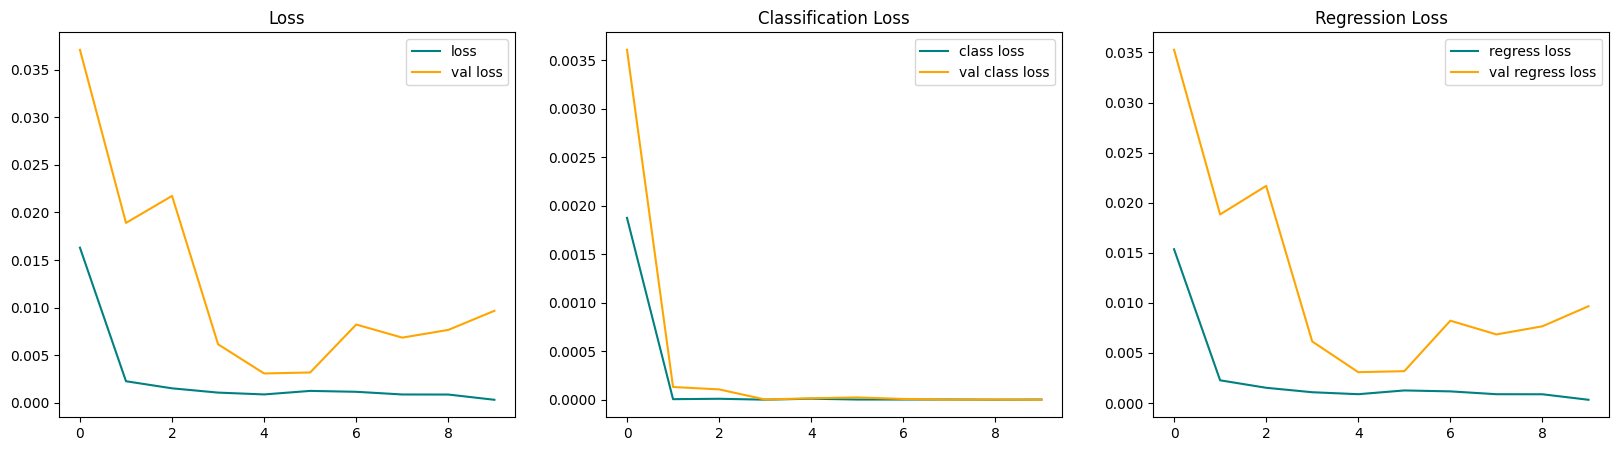

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))
# Total Loss
ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

# Classification loss
ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

# Regression loss
ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 9. Making Prediction (On test set)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


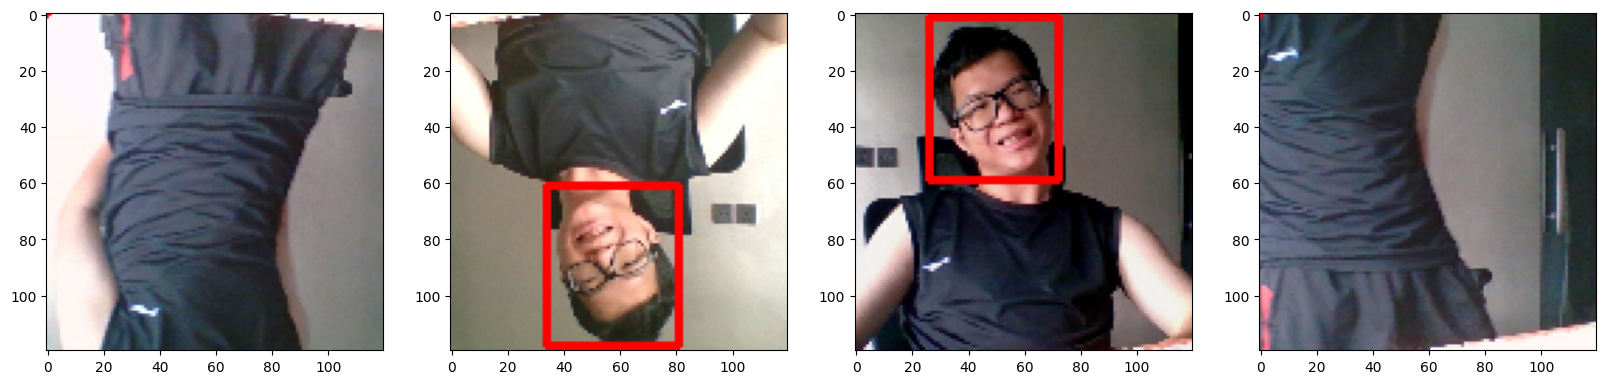

In [ ]:
# Sample the test set
test_data = test.as_numpy_iterator()
test_sample = test_data.next()
# The prediction
yhat = facetracker.predict(test_sample[0])
# Plot the prediction
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]

    # Create a copy of the image, since we cannot read the file in read-only mode
    sample_image_copy = sample_image.copy()

    # Draw the rectangle on the copy
    cv2.rectangle(sample_image_copy,  # Pass the copy to cv2.rectangle
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                        (255,0,0), 2)

    ax[idx].imshow(sample_image_copy)

# 10. Real Time Prediction

In [ ]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))

    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]

    if yhat[0] > 0.5:
        # Controls the main rectangle
        cv2.rectangle(frame,
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)),
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame,
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])),
                            (255,0,0), -1)

        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

    cv2.imshow('EyeTrack', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()